In [20]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like, compute_num_params
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
from src.models import LeNet
from src.data.datasets import get_rotated_mnist_loaders
from src.ood_functions.evaluate import evaluate, evaluate_map
from src.ood_functions.metrics import compute_metrics
from src.data import n_classes, MNIST

In [21]:
# param_dict = pickle.load(open("../checkpoints/MNIST/posterior_samples_params.pickle", "rb"))
param_dict = pickle.load(open("../checkpoints/MNIST/posterior_samples_test_seed0_params.pickle", "rb"))

lr_posterior = param_dict['Non-ker-eigvals']
posterior = param_dict['full-samples']
n_steps = 20
n_samples = 5
alpha = 1.0
rho = 1.0
rank = 1000
original_params = pickle.load(open("../checkpoints/MNIST/LeNet/OOD_MNIST_seed420_params.pickle", "rb"))
params, alpha, rho, model_id = original_params['params'], original_params['prior_precision'], original_params['likelihood_precision'], original_params['model']
if model_id == 'LeNet':
    model = LeNet(output_dim=10, activation="tanh")


In [22]:
cls = list(range(n_classes("MNIST")))
dataset = MNIST(path_root="/work3/hroy/data/", train=True, n_samples_per_class=None, download=True, cls=cls, seed=420)
x_train = jnp.array([data[0] for data in dataset])

eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"


In [23]:
ids = [0, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):    
    _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))


R-MNIST with distribution shift intensity 0
conf: 0.9923, nll: 20.6199, acc: 0.9920, brier: 0.0158, ece: 0.1496, mce: 0.6762


/work3/hroy/geometric-laplace/geom/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work3/hroy/geometric-laplace/geom/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/work3/hroy/geometric-laplace/geom/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


R-MNIST with distribution shift intensity 1
conf: 0.9760, nll: 94.9733, acc: 0.9540, brier: 0.0788, ece: 0.2372, mce: 0.8613
R-MNIST with distribution shift intensity 2
conf: 0.9264, nll: 522.0819, acc: 0.7780, brier: 0.3581, ece: 0.3216, mce: 0.8079
R-MNIST with distribution shift intensity 3
conf: 0.8454, nll: 2678.5547, acc: 0.2520, brier: 1.2863, ece: 0.5758, mce: 0.9148
R-MNIST with distribution shift intensity 4
conf: 0.8011, nll: 3162.5386, acc: 0.1340, brier: 1.4383, ece: 0.6357, mce: 0.9558
R-MNIST with distribution shift intensity 5
conf: 0.7998, nll: 2896.4175, acc: 0.1900, brier: 1.3353, ece: 0.5766, mce: 0.9447
R-MNIST with distribution shift intensity 6
conf: 0.8594, nll: 3259.4871, acc: 0.3060, brier: 1.2029, ece: 0.5033, mce: 0.8940
R-MNIST with distribution shift intensity 7
conf: 0.8894, nll: 3220.7656, acc: 0.3780, brier: 1.0938, ece: 0.5090, mce: 0.8424
R-MNIST with distribution shift intensity 8
conf: 0.8570, nll: 3152.6396, acc: 0.3400, brier: 1.1456, ece: 0.5239,

In [24]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"


In [25]:
ids = [0, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):    
    _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_posterior.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))


R-MNIST with distribution shift intensity 0
conf: 0.7446, nll: 3615.1814, acc: 0.0900, brier: 1.4658, ece: 0.6387, mce: 0.9746
R-MNIST with distribution shift intensity 1
conf: 0.7435, nll: 3659.9395, acc: 0.0820, brier: 1.4771, ece: 0.6463, mce: 0.9644
R-MNIST with distribution shift intensity 2
conf: 0.7575, nll: 3509.1082, acc: 0.0880, brier: 1.4794, ece: 0.6507, mce: 0.9545
R-MNIST with distribution shift intensity 3
conf: 0.7554, nll: 3539.2302, acc: 0.0740, brier: 1.5016, ece: 0.6570, mce: 0.9845
R-MNIST with distribution shift intensity 4
conf: 0.7562, nll: 3533.0508, acc: 0.1140, brier: 1.4434, ece: 0.6311, mce: 0.9656
R-MNIST with distribution shift intensity 5
conf: 0.7718, nll: 3642.4448, acc: 0.1060, brier: 1.4692, ece: 0.6389, mce: 0.9661
R-MNIST with distribution shift intensity 6
conf: 0.7412, nll: 3206.0862, acc: 0.1300, brier: 1.4023, ece: 0.5923, mce: 0.9549
R-MNIST with distribution shift intensity 7
conf: 0.7319, nll: 3263.2407, acc: 0.0900, brier: 1.4515, ece: 0.62

In [26]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"


In [27]:
ids = [0, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lienarised = []
for i, id in enumerate(ids):    
    _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_lienarised.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lienarised[-1].items()]))


R-MNIST with distribution shift intensity 0
conf: 0.9160, nll: 4831.6455, acc: 0.3400, brier: 1.2109, ece: 0.5540, mce: 0.9155
R-MNIST with distribution shift intensity 1
conf: 0.9274, nll: 5906.5166, acc: 0.3540, brier: 1.1971, ece: 0.5812, mce: 0.9171
R-MNIST with distribution shift intensity 2
conf: 0.9386, nll: 7484.3799, acc: 0.3620, brier: 1.1919, ece: 0.6003, mce: 0.9232
R-MNIST with distribution shift intensity 3
conf: 0.9454, nll: 13061.9902, acc: 0.1860, brier: 1.5467, ece: 0.7285, mce: 0.9748
R-MNIST with distribution shift intensity 4
conf: 0.9258, nll: 15836.4219, acc: 0.1060, brier: 1.6878, ece: 0.6790, mce: 0.9455
R-MNIST with distribution shift intensity 5
conf: 0.9428, nll: 16589.9844, acc: 0.0940, brier: 1.7350, ece: 0.7212, mce: 0.9448
R-MNIST with distribution shift intensity 6
conf: 0.9458, nll: 14863.2539, acc: 0.0580, brier: 1.8045, ece: 0.7544, mce: 0.9754
R-MNIST with distribution shift intensity 7
conf: 0.9385, nll: 13607.5215, acc: 0.0820, brier: 1.7476, ece:

In [28]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):    
    _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_map.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))


R-MNIST with distribution shift intensity 0
conf: 0.9923, nll: 20.6507, acc: 0.9920, brier: 0.0158, ece: 0.1528, mce: 0.6710
R-MNIST with distribution shift intensity 1
conf: 0.9761, nll: 94.8009, acc: 0.9540, brier: 0.0787, ece: 0.2289, mce: 0.8603
R-MNIST with distribution shift intensity 2
conf: 0.9263, nll: 521.2623, acc: 0.7760, brier: 0.3576, ece: 0.3182, mce: 0.7842
R-MNIST with distribution shift intensity 3
conf: 0.8451, nll: 2676.1758, acc: 0.2520, brier: 1.2856, ece: 0.5750, mce: 0.8485
R-MNIST with distribution shift intensity 4
conf: 0.8010, nll: 3161.3896, acc: 0.1340, brier: 1.4378, ece: 0.6356, mce: 0.9560
R-MNIST with distribution shift intensity 5
conf: 0.7999, nll: 2896.1040, acc: 0.1900, brier: 1.3353, ece: 0.5677, mce: 0.9438
R-MNIST with distribution shift intensity 6
conf: 0.8594, nll: 3259.6318, acc: 0.3060, brier: 1.2027, ece: 0.4954, mce: 0.8925
R-MNIST with distribution shift intensity 7
conf: 0.8896, nll: 3221.7534, acc: 0.3780, brier: 1.0938, ece: 0.5087, m

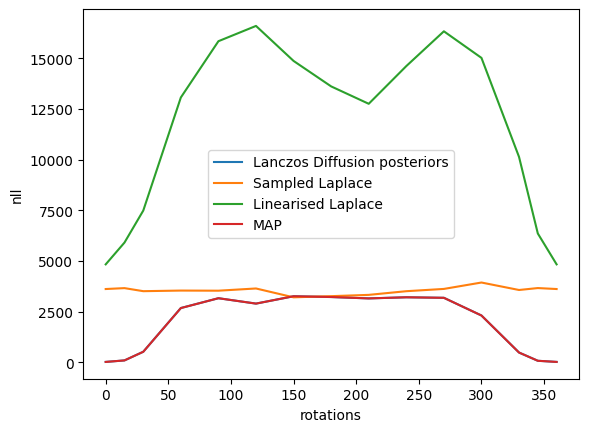

In [29]:
uq_metric = 'nll'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Lanczos Diffusion posteriors")
plt.plot(ids, [post[uq_metric] for post in metrics_posterior], label="Sampled Laplace")
plt.plot(ids, [lin[uq_metric] for lin in metrics_lienarised], label="Linearised Laplace")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

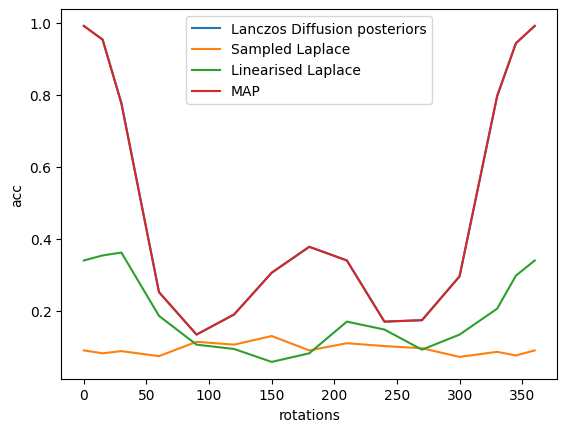

In [30]:
uq_metric = 'acc'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Lanczos Diffusion posteriors")
plt.plot(ids, [post[uq_metric] for post in metrics_posterior], label="Sampled Laplace")
plt.plot(ids, [lin[uq_metric] for lin in metrics_lienarised], label="Linearised Laplace")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

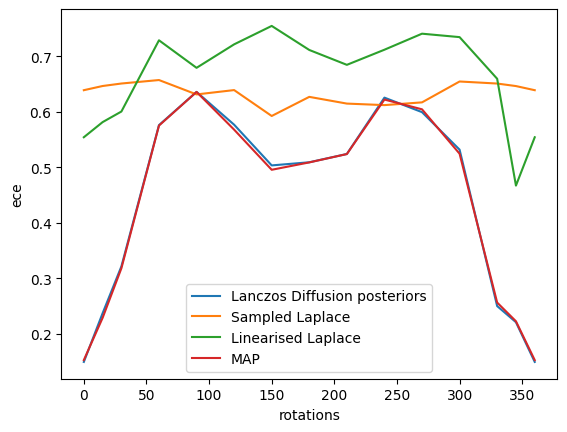

In [31]:
uq_metric = 'ece'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Lanczos Diffusion posteriors")
plt.plot(ids, [post[uq_metric] for post in metrics_posterior], label="Sampled Laplace")
plt.plot(ids, [lin[uq_metric] for lin in metrics_lienarised], label="Linearised Laplace")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

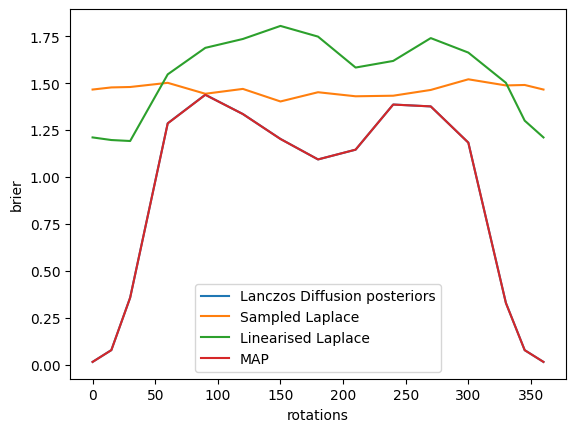

In [32]:
uq_metric = 'brier'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Lanczos Diffusion posteriors")
plt.plot(ids, [post[uq_metric] for post in metrics_posterior], label="Sampled Laplace")
plt.plot(ids, [lin[uq_metric] for lin in metrics_lienarised], label="Linearised Laplace")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

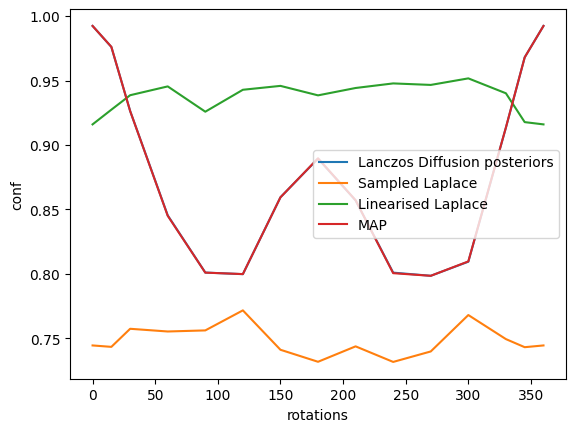

In [33]:
uq_metric = 'conf'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Lanczos Diffusion posteriors")
plt.plot(ids, [post[uq_metric] for post in metrics_posterior], label="Sampled Laplace")
plt.plot(ids, [lin[uq_metric] for lin in metrics_lienarised], label="Linearised Laplace")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()